In [ ]:
import os
import json
import copy
import numpy as np
from tqdm import tqdm

from mmdet.apis import init_detector, inference_detector

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from mmpose.apis import init_model as init_pose_model, inference_topdown

In [ ]:
det_config_path = '/mnt/nas_siddharth/sn_code/model/detection/mask_rcnn_swin_s_macaque_bbox.py'  
det_checkpoint   = '/mnt/nas_siddharth/sn_code/weight/sn_detection.pth'
det_data_root    = '/mnt/nas_siddharth/dataset/macaquegcage_coco2'
det_anno_file    = os.path.join(det_data_root, 'annotations', 'test.json')
det_img_folder   = os.path.join(det_data_root, 'images')

pose_config_path = '/mnt/nas_siddharth/macaque_pose_training_sn/td-hm_ViTPose-huge_8xb64-210e_coco-256x192_sn_macaque.py'
pose_checkpoint  = '/mnt/nas_siddharth/macaque_pose_training_sn/best_coco_AP_epoch_60.pth'
pose_data_root   = det_data_root
pose_anno_file   = det_anno_file
pose_img_folder  = det_img_folder

In [ ]:
def run_detection_inference(det_model, coco_gt):
    """
    For every image in coco_gt, run inference_detector(det_model, img_path).
    Extracts pred_instances.bboxes, pred_instances.scores, pred_instances.labels
    from the returned DetDataSample and converts them into COCO-style dicts:
      [{'image_id':..., 'category_id':..., 'bbox':[x,y,w,h], 'score':...}, ...]
    """
    all_detections = []
    for img_info in tqdm(coco_gt.loadImgs(coco_gt.getImgIds()), desc='Detecting'):
        img_path = os.path.join(det_img_folder, img_info['file_name'])
        outputs = inference_detector(det_model, img_path)

        # inference_detector can return either a single DetDataSample or a list thereof
        if isinstance(outputs, (list, tuple)):
            data_sample = outputs[0]
        else:
            data_sample = outputs

        pred_ins = data_sample.pred_instances
        bboxes   = pred_ins.bboxes.cpu().numpy()   # shape (N, 4): [x1, y1, x2, y2]
        scores   = pred_ins.scores.cpu().numpy()   # shape (N,)
        labels   = pred_ins.labels.cpu().numpy()   # shape (N,); 0-indexed

        for (x1, y1, x2, y2), score, label in zip(bboxes, scores, labels):
            w = float(x2 - x1)
            h = float(y2 - y1)
            all_detections.append({
                'image_id':    img_info['id'],
                'category_id': int(label) + 1,  # COCO categories start at 1
                'bbox':        [float(x1), float(y1), w, h],
                'score':       float(score)
            })
    return all_detections

In [ ]:
def run_pose_inference(pose_model, det_results, coco_gt, det_score_thr):
    # Group detections by image_id
    boxes_per_image = {}
    for det in det_results:
        if det['score'] >= det_score_thr:
            img_id = det['image_id']
            boxes_per_image.setdefault(img_id, []).append(det)

    pose_preds = []
    for img_id, dets_in_img in boxes_per_image.items():
        img_info = coco_gt.loadImgs(img_id)[0]
        img_path = os.path.join(pose_img_folder, img_info['file_name'])

        # Build just the list of bboxes; drop any reference to person_results or scores
        bboxes_xyxy = []
        for det in dets_in_img:
          x, y, w, h = det['bbox']
          x1, y1 = x, y
          x2, y2 = x + w, y + h
          bboxes_xyxy.append([x1, y1, x2, y2])

        # Now call inference_topdown with only bboxes and format
        pose_out_list = inference_topdown(
            pose_model,
            img=img_path,
            bboxes=bboxes_xyxy,
        )

        for res in pose_out_list:
            keypoint_tensor = res.pred_instances.keypoints  # a NumPy array
            kp = keypoint_tensor[0] 
            if kp.shape[1] == 2:
                K = kp.shape[0]
                v_channel = np.ones((K, 1), dtype=kp.dtype)
                kp = np.concatenate([kp, v_channel], axis=1)  # now (K, 3)
            keypoints = kp.reshape(-1).tolist()
            avg_conf  = float(kp[:, 2].mean())
            pose_preds.append({
                'image_id':    img_id,
                'category_id': 1,
                'keypoints':   keypoints,
                'score':       avg_conf
            })

    return pose_preds


In [ ]:
# COCO GT (bbox + kp)
coco_gt = COCO(det_anno_file)

print("Loading detection model...")
det_model = init_detector(det_config_path, det_checkpoint, device='cuda:0')

print("Running full set detection inference...")
raw_det_results = run_detection_inference(det_model, coco_gt)
print(f"  → Obtained {len(raw_det_results)} total detections across all images.")

det_thr_list    = np.linspace(0.00, 1.00, 21)  # 0.00, 0.05, 0.10, …, 1.00
det_map_per_thr = []

print("\nSweeping detection thresholds for bbox mAP:")
for thr in det_thr_list:
    filtered_boxes = [d for d in raw_det_results if d['score'] >= thr]
    if len(filtered_boxes) == 0:
        det_map_per_thr.append(0.0)
        print(f"  Det thr {thr:.2f} → no boxes, mAP=0.0000")
        continue

    coco_dt = coco_gt.loadRes(filtered_boxes)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    mAP_bbox = coco_eval.stats[0]  # AP @[.50:.95]
    det_map_per_thr.append(mAP_bbox)
    print(f"  Det thr {thr:.2f} → mAP: {mAP_bbox:.4f}")

best_det_idx = int(np.argmax(det_map_per_thr))
best_det_thr = float(det_thr_list[best_det_idx])
best_det_map = float(det_map_per_thr[best_det_idx])
print(f"\n→ Best detection threshold = {best_det_thr:.2f}  (bbox mAP = {best_det_map:.4f})")


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Loading detection model...
Loads checkpoint by local backend from path: /mnt/nas_siddharth/sn_code/weight/sn_detection.pth
Running full‐set detection inference (this may take a while)...


Detecting: 100%|██████████| 200/200 [00:28<00:00,  7.10it/s]


  → Obtained 673 total detections across all images.

Sweeping detection thresholds for bbox‐mAP:
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [ ]:
print("\nLoading pose model...")
pose_model = init_pose_model(pose_config_path, pose_checkpoint, device='cuda:0')

pose_map_per_det_thr = []

print("\nSweeping pose thresholds (for each detection threshold):")
# For every det_score thr, find the best possible kp AP
for det_thr in det_thr_list:
    #Run pose inference on all boxes with score >= det_thr
    pose_predictions = run_pose_inference(pose_model, raw_det_results, coco_gt, det_thr)
    if len(pose_predictions) == 0:
        pose_map_per_det_thr.append(0.0)
        print(f"  Det thr {det_thr:.2f} → no pose predictions, keypointAP=0.0000")
        continue

    pose_thr_list    = np.linspace(0.00, 1.00, 21)
    best_kpAP_for_dt = 0.0

    for pose_thr in pose_thr_list:
        filtered_kp = [pp for pp in pose_predictions if pp['score'] >= pose_thr]
        if len(filtered_kp) == 0:
            continue

        coco_kp_dt = coco_gt.loadRes(filtered_kp)

        coco_eval_kp = COCOeval(coco_gt, coco_kp_dt, iouType='keypoints')
        coco_eval_kp.evaluate()
        coco_eval_kp.accumulate()
        coco_eval_kp.summarize()
        kpAP = coco_eval_kp.stats[0]  # keypoint AP @[.50:.95]
        if kpAP > best_kpAP_for_dt:
            best_kpAP_for_dt = kpAP

    pose_map_per_det_thr.append(best_kpAP_for_dt)
    print(f"  Det thr {det_thr:.2f} → best keypoint AP over pose thresholds = {best_kpAP_for_dt:.4f}")

best_pose_idx    = int(np.argmax(pose_map_per_det_thr))
best_det_for_pose = float(det_thr_list[best_pose_idx])
best_pose_map     = float(pose_map_per_det_thr[best_pose_idx])
print(f"\n→ Best detection threshold (for pose) = {best_det_for_pose:.2f}  (keypoint AP = {best_pose_map:.4f})")


Loading pose model...
Loads checkpoint by local backend from path: /mnt/nas_siddharth/macaque_pose_training_sn/best_coco_AP_epoch_60.pth

Sweeping pose thresholds (for each detection threshold):


/home/siddharth/miniconda3/envs/openmmlab/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.963
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.892
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDe

In [ ]:
print(f"Optimal detection threshold  = {best_det_thr:.2f}  (bbox mAP = {best_det_map:.4f})")
print(f"Detection threshold for best pose = {best_det_for_pose:.2f}  (keypoint AP = {best_pose_map:.4f})")


────────────────────────────────────────────────────────────
Optimal detection threshold  = 0.00  (bbox‐mAP = 0.7195)
Detection threshold for best pose = 0.85  (keypoint AP = 0.7203)
────────────────────────────────────────────────────────────


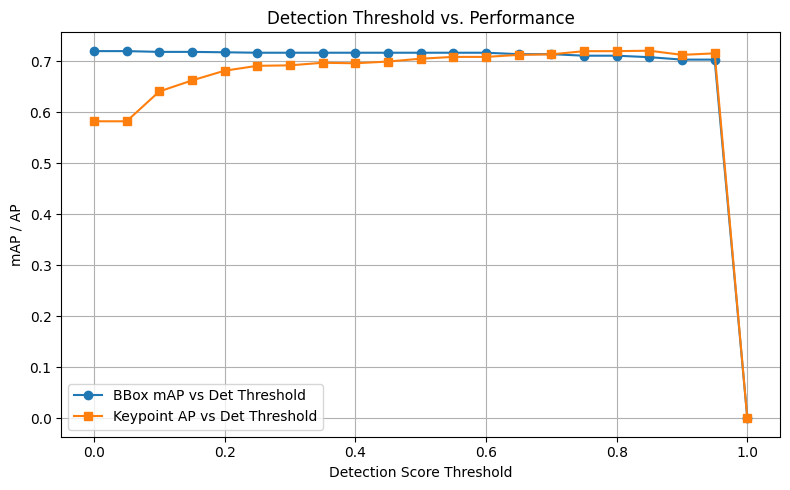

Best bbox‐mAP @ det_thr = 0.00 → mAP = 0.7195
Best keypoint AP @ det_thr = 0.85 → AP = 0.7203


In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual variables from the previous cell:
#   det_thr_list        # e.g. np.linspace(0.00, 1.00, 21)
#   det_map_per_thr     # list or array of bbox‐mAP values
#   pose_map_per_det_thr  # list or array of best keypoint AP values per det threshold

plt.figure(figsize=(8, 5))
plt.plot(det_thr_list, det_map_per_thr, label='BBox mAP vs Det Threshold', marker='o')
plt.plot(det_thr_list, pose_map_per_det_thr, label='Keypoint AP vs Det Threshold', marker='s')

plt.xlabel('Detection Score Threshold')
plt.ylabel('mAP / AP')
plt.title('Detection Threshold vs. Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_det_idx = det_map_per_thr.index(max(det_map_per_thr))
print(f"Best bbox mAP @ det_thr = {det_thr_list[best_det_idx]:.2f} → mAP = {det_map_per_thr[best_det_idx]:.4f}")

best_pose_idx = pose_map_per_det_thr.index(max(pose_map_per_det_thr))
print(f"Best keypoint AP @ det_thr = {det_thr_list[best_pose_idx]:.2f} → AP = {pose_map_per_det_thr[best_pose_idx]:.4f}")



In [10]:
from mmengine.config import Config

# Load your MMPose config file
cfg = Config.fromfile('/mnt/nas_siddharth/macaque_pose_training_sn/td-hm_ViTPose-huge_8xb64-210e_coco-256x192_sn_macaque.py')

# Usually the path is relative, so adjust as needed:
dataset_info_path = '/mnt/nas_siddharth/sn_code/model/pose/macaque.py'
dataset_info_cfg = Config.fromfile(dataset_info_path)
dataset_info = dataset_info_cfg['dataset_info'] if 'dataset_info' in dataset_info_cfg else dataset_info_cfg.dataset_info


In [11]:
print("KEYPOINTS:")
for k in sorted(dataset_info['keypoint_info'].keys()):
    info = dataset_info['keypoint_info'][k]
    print(f"{k}: {info['name']}")


KEYPOINTS:
0: nose
1: left_eye
2: right_eye
3: left_ear
4: right_ear
5: left_shoulder
6: right_shoulder
7: left_elbow
8: right_elbow
9: left_wrist
10: right_wrist
11: left_hip
12: right_hip
13: left_knee
14: right_knee
15: left_ankle
16: right_ankle


In [ ]:
print("\nSKELETON PAIRS:")
for s in sorted(dataset_info['skeleton_info'].keys()):
    skel = dataset_info['skeleton_info'][s]
    print(f"{s}: {skel['link']}")
